In [4]:
from __future__ import division
import numpy as np
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import graphlab

In [5]:
#balanced accuracy
def Balanced_acc(ypred,ytest):
    acc_c = 0
    acc_class = np.zeros(5) #the accuracy per class
    for c in np.unique(ytest):
        i = ytest == c
        correct = ypred[i] == ytest[i]
        acc_c += sum(correct)/len(correct)
        acc_class[c] = sum(correct)/len(correct)

    Bacc = acc_c/len(np.unique(ytest))
    return Bacc,acc_class

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, ['Sit','StairsUp','StairsDw','Stand','Walk'], rotation=45)
    plt.yticks(tick_marks, ['Sit','StairsUp','StairsDw','Stand','Walk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Load Data

In [6]:
HealthyData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/HealthyData.csv',verbose=False)
CBRData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/PatientCBRData.csv',verbose=False)
SCOData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/PatientSCOData.csv',verbose=False)

This non-commercial license of GraphLab Create for academic use is assigned to llonini@ricres.org and will expire on November 11, 2016.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\llonini\AppData\Local\Temp\graphlab_server_1475252075.log.0


In [7]:
HealthyCodes = HealthyData['SubjID'].unique()
HealthyCodes = HealthyCodes.sort()
print HealthyCodes
PatientCodes = CBRData['SubjID'].unique()
PatientCodes = PatientCodes.sort()
print PatientCodes

[51L, 52L, 53L, 54L, 55L, 56L, 57L, 58L, 59L, 60L, 61L]
[1L, 2L, 5L, 6L, 8L, 11L, 12L, 13L, 14L, 15L, 16L, 19L]


In [8]:
PatientCodes = np.array([1, 2, 5, 6, 8, 11, 14, 15, 16, 19]) #all patients with 4 sessions in SCO and CBR

### We use 4 sessions from both CBR and SCO data. Remove stairs CBR data for patients who don't have at least 2 sessions with stairs data

Inspect SCO Data

In [12]:
for s in PatientCodes:
    data = SCOData[SCOData['SubjID']==s]
    for sess in np.unique(data['Session']):
        print s,sess,np.unique(data[data['Session']==sess]['Label'].unique().sort())

1 1 [0 1 2 3 4]
1 2 [0 1 2 3 4]
1 3 [0 1 2 3 4]
1 4 [0 1 2 3 4]
2 1 [0 1 2 3 4]
2 2 [0 1 2 3 4]
2 3 [0 3 4]
2 4 [0 1 2 3 4]
5 1 [0 3 4]
5 2 [0 1 2 3 4]
5 3 [0 1 2 3 4]
6 1 [0 1 2 3 4]
6 2 [0 1 2 3 4]
6 3 [0 1 2 3 4]
6 4 [0 1 2 3 4]
8 1 [0 1 2 3 4]
8 2 [0 3 4]
8 3 [0 3 4]
8 4 [0 3 4]
11 1 [0 3 4]
11 2 [0 3 4]
11 3 [0 3 4]
11 4 [0 1 2 3 4]
14 1 [0 1 2 3 4]
14 2 [0 1 2 3 4]
14 3 [0 1 2 3 4]
14 4 [0 1 2 3 4]
15 1 [0 3 4]
15 2 [0 3 4]
15 3 [0 1 2 3 4]
16 1 [0 1 2 3 4]
16 2 [0 3 4]
16 3 [0 1 2 3 4]
16 4 [0 1 2 3 4]
19 1 [0 3 4]
19 2 [0 1 2 3 4]
19 3 [0 3 4]


In [13]:
print SCOData.num_rows()

18762


Inspect CBR Data

In [21]:
for s in PatientCodes:
    data = CBRData[CBRData['SubjID']==s]
    for sess in np.unique(data['Session']):
        print s,sess,np.unique(data[data['Session']==sess]['Label'].unique().sort())


1 1 [0 1 2 3 4]
1 2 [0 1 2 3 4]
1 3 [0 1 2 3 4]
1 4 [0 1 2 3 4]
2 1 [0 1 2 3 4]
2 2 [0 1 2 3 4]
2 3 [0 1 2 3 4]
2 4 [0 1 2 3 4]
5 1 [0 1 2 3 4]
5 2 [0 1 2 3 4]
5 3 [0 1 2 3 4]
5 4 [0 1 2 3 4]
6 1 [0 1 3 4]
6 2 [0 1 2 3 4]
6 3 [0 1 2 3 4]
6 4 [0 1 2 3 4]
8 1 [0 3 4]
8 2 [0 3 4]
8 3 [0 3 4]
8 4 [0 3 4]
11 1 [0 3 4]
11 2 [0 1 2 3 4]
11 3 [0 1 2 3 4]
11 4 [0 1 2 3 4]
14 1 [0 3 4]
14 2 [0 3 4]
14 3 [0 1 2 3 4]
14 4 [0 1 2 3 4]
15 1 [0 3 4]
15 2 [0 1 2 3 4]
15 3 [0 3 4]
15 4 [0 1 2 3 4]
16 1 [0 1 2 3 4]
16 2 [0 1 2 3 4]
16 3 [0 1 2 3 4]
16 4 [0 1 2 3 4]
19 1 [0 3 4]
19 2 [0 3 4]
19 3 [0 3 4]
19 4 [0 3 4]


* Remove stairs from CBR08 

In [16]:
Nostairs = [8] #the patient to remove stairs 
CBRDatanew = CBRData.filter_by(Nostairs,'SubjID',exclude=True)
for s in Nostairs:
    data = CBRData[(CBRData['SubjID']==s)].filter_by([0,3,4],'Label')
    CBRDatanew=CBRDatanew.append(data)

for s in PatientCodes:
    print s,CBRDatanew[CBRDatanew['SubjID']==s]['Label'].unique().sort()

1 [0L, 1L, 2L, 3L, 4L]
2 [0L, 1L, 2L, 3L, 4L]
5 [0L, 1L, 2L, 3L, 4L]
6 [0L, 1L, 2L, 3L, 4L]
8 [0L, 3L, 4L]
11 [0L, 1L, 2L, 3L, 4L]
14 [0L, 1L, 2L, 3L, 4L]
15 [0L, 1L, 2L, 3L, 4L]
16 [0L, 1L, 2L, 3L, 4L]
19 [0L, 3L, 4L]


All the CBR subjects have stairs except 2 of them

In [17]:
print CBRData.num_rows()
print CBRDatanew.num_rows()

22354
22323


In [18]:
CBRData = CBRDatanew

## Train RF on healthy 

In [20]:
col_names = HealthyData.column_names()
label_cols = col_names[-1:] #the : is used to return a list with one element 
feature_cols = col_names[2:-1]

Xtrain = HealthyData.select_columns(feature_cols).to_numpy()
ytrain = HealthyData.select_columns(label_cols).to_numpy()
ytrain = ytrain.reshape(-1) #to squeeze last dimension and obtain a 1D array

RF = RandomForestClassifier(n_estimators=100)
RF = RF.fit(Xtrain,ytrain)

#test on each patient (CBR)
SOacc = np.zeros(len(PatientCodes))
acc_class_subj = [] #accuracy per class for each subject


k = 0

for s in PatientCodes:
    test = CBRData[(CBRData['SubjID'] == s)]
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1) #to squeeze last dimension and obtain a 1D array
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    print 'Test on Patient %s, Train samples=%s, Test samples=%s, Nclass test=%s'%(s,len(ytrain),len(ytest),Nclasses)
    ypred = RF.predict(Xtest)

    #acc = sum(ypred == ytest)/len(ytest)
    #SOacc[k] = acc

    #balanced accuracy
    SOacc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)    
    print 'BAcc = {:.2f}'.format(SOacc[k])
    k = k+1

print '\nmedian Bacc - Healthy model = %s'%np.median(SOacc)

Test on Patient 1, Train samples=8375, Test samples=1678, Nclass test=5
BAcc = 0.48
Test on Patient 2, Train samples=8375, Test samples=1458, Nclass test=5
BAcc = 0.34
Test on Patient 5, Train samples=8375, Test samples=1773, Nclass test=5
BAcc = 0.45
Test on Patient 6, Train samples=8375, Test samples=2916, Nclass test=5
BAcc = 0.58
Test on Patient 8, Train samples=8375, Test samples=1179, Nclass test=3
BAcc = 0.34
Test on Patient 11, Train samples=8375, Test samples=1708, Nclass test=5
BAcc = 0.52
Test on Patient 14, Train samples=8375, Test samples=1976, Nclass test=5
BAcc = 0.49
Test on Patient 15, Train samples=8375, Test samples=3511, Nclass test=5
BAcc = 0.48
Test on Patient 16, Train samples=8375, Test samples=1734, Nclass test=5
BAcc = 0.59
Test on Patient 19, Train samples=8375, Test samples=1565, Nclass test=3
BAcc = 0.54

median Bacc - Healthy model = 0.487269560388


## Global model SCO (Leave one subject out)

In [22]:
ISpec_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    train = SCOData[(SCOData['SubjID'] != s)]
    test = CBRData[(CBRData['SubjID'] == s)] 
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    
    RF = RandomForestClassifier(n_estimators=100)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    ISpec_acc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)   
    print 'Patient {}, Nclass train = {}, Nclass test = {}, Impairment specific (SCO) model - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,ISpec_acc[k])
    k = k+1

print 'Median BAcc - Impairment Specific (SCO) = %s'%np.median(ISpec_acc)

Patient 1, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.52
Patient 2, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.42
Patient 5, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.47
Patient 6, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.55
Patient 8, Nclass train = 5, Nclass test = 3, Impairment specific (SCO) model - BAcc = 0.50
Patient 11, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.57
Patient 14, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.59
Patient 15, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.56
Patient 16, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.55
Patient 19, Nclass train = 5, Nclass test = 3, Impairment specific (SCO) model - BAcc = 0.84
Median BAcc - Impairment Specific (SCO) = 0.552865293212


## Global model CBR (Leave one subject out)

In [24]:
ISpecCBR_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    train = CBRData[(CBRData['SubjID'] != s)]
    test = CBRData[(CBRData['SubjID'] == s)] #test on 3 CBR sessions
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    
    RF = RandomForestClassifier(n_estimators=100,random_state=0)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    ISpecCBR_acc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)   
    print 'Patient {}, Nclass train = {}, Nclass test = {}, Global CBR model - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,ISpecCBR_acc[k])
    k = k+1

print 'Median BAcc - Global CBR model = %s'%np.median(ISpecCBR_acc)

Patient 1, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.61
Patient 2, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.44
Patient 5, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.54
Patient 6, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.57
Patient 8, Nclass train = 5, Nclass test = 3, Global CBR model - BAcc = 0.56
Patient 11, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.57
Patient 14, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.54
Patient 15, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.60
Patient 16, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.60
Patient 19, Nclass train = 5, Nclass test = 3, Global CBR model - BAcc = 0.88
Median BAcc - Global CBR model = 0.57144592259


## Train on SCO and test on CBR (Patient Specific model) 

In [23]:
PSpec_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    train = SCOData[(SCOData['SubjID'] == s)]
    test = CBRData[(CBRData['SubjID'] == s)]
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    
    RF = RandomForestClassifier(n_estimators=50)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    PSpec_acc[k],acc_class = Balanced_acc(ypred,ytest)
    
    print 'Patient {}, Nclass train = {}, Nclass test = {}, Personal model (Trained on SCO) - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,PSpec_acc[k])
    k = k+1

print 'Median BAcc - Patient Specific (SCO) = %s'%np.median(PSpec_acc)

Patient 1, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.72
Patient 2, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.49
Patient 5, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.63
Patient 6, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.61
Patient 8, Nclass train = 5, Nclass test = 3, Personal model (Trained on SCO) - BAcc = 0.77
Patient 11, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.46
Patient 14, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.53
Patient 15, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.49
Patient 16, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.50
Patient 19, Nclass train = 5, Nclass test = 3, Personal model (Trained on SCO) - BAcc = 0.79
Median BAcc - Patient Specific (SCO) = 0.57368818819


## Patient and Device specific model (CBR) - Leave One Session Out 

In [26]:
range(1,5)

[1, 2, 3, 4]

In [31]:
DSpec_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    data =  CBRData[(CBRData['SubjID'] == s)] 
    Bacc = np.zeros(4)
    for session in range(1,5):
                  
        test = data[data['Session'] == session]
        train = data[data['Session'] != session]
        Nclasstrain = len(train['Label'].unique())
        Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

        Xtrain = train.select_columns(feature_cols).to_numpy()
        ytrain = train.select_columns(label_cols).to_numpy()
        ytrain = ytrain.reshape(-1)
        Xtest = test.select_columns(feature_cols).to_numpy()
        ytest = test.select_columns(label_cols).to_numpy()
        ytest = ytest.reshape(-1)

        RF = RandomForestClassifier(n_estimators=50)
        RF = RF.fit(Xtrain,ytrain)
        ypred = RF.predict(Xtest)
        #acc = sum(ypred == ytest)/len(ytest)
        #balanced accuracy on each session
        Bacc[session-1],acc_class = Balanced_acc(ypred,ytest)
        print 'Nclass train = {}, Nclass test ={}, BAcc = {:.2f}'.format(Nclasstrain,Nclasses,Bacc[session-1])

    DSpec_acc[k] = Bacc.mean() #the CV BAcc on 3 sessions 
    print 'Patient {}, Device Specific model - BAcc = {:.2f}'.format(s,DSpec_acc[k])
    k = k+1

print 'Median BAcc - Device Specific (CBR) = %s'%np.median(DSpec_acc)

Nclass train = 5, Nclass test =5, BAcc = 0.86
Nclass train = 5, Nclass test =5, BAcc = 0.85
Nclass train = 5, Nclass test =5, BAcc = 0.88
Nclass train = 5, Nclass test =5, BAcc = 0.74
Patient 1, Device Specific model - BAcc = 0.84
Nclass train = 5, Nclass test =5, BAcc = 0.75
Nclass train = 5, Nclass test =5, BAcc = 0.54
Nclass train = 5, Nclass test =5, BAcc = 0.72
Nclass train = 5, Nclass test =5, BAcc = 0.58
Patient 2, Device Specific model - BAcc = 0.64
Nclass train = 5, Nclass test =5, BAcc = 0.70
Nclass train = 5, Nclass test =5, BAcc = 0.59
Nclass train = 5, Nclass test =5, BAcc = 0.66
Nclass train = 5, Nclass test =5, BAcc = 0.70
Patient 5, Device Specific model - BAcc = 0.66
Nclass train = 5, Nclass test =4, BAcc = 0.68
Nclass train = 5, Nclass test =5, BAcc = 0.51
Nclass train = 5, Nclass test =5, BAcc = 0.62
Nclass train = 5, Nclass test =5, BAcc = 0.77
Patient 6, Device Specific model - BAcc = 0.65
Nclass train = 3, Nclass test =3, BAcc = 0.92
Nclass train = 3, Nclass test 

In [32]:
acc_all=np.vstack((SOacc,ISpec_acc,PSpec_acc,DSpec_acc)).T
print acc_all

[[ 0.48298527  0.52099959  0.71821111  0.83621866]
 [ 0.34437885  0.41904023  0.48740246  0.64440573]
 [ 0.45225881  0.47068381  0.62645498  0.6614866 ]
 [ 0.58308531  0.551398    0.61301841  0.64513608]
 [ 0.34432134  0.49734316  0.77364931  0.90150699]
 [ 0.52072587  0.5672036   0.46337939  0.66125236]
 [ 0.49155385  0.58938643  0.53435797  0.80886127]
 [ 0.481689    0.55877392  0.49354566  0.7790484 ]
 [ 0.58665849  0.55433259  0.5042735   0.75393997]
 [ 0.54362576  0.84007384  0.79297314  0.78107457]]


<function matplotlib.pyplot.show>

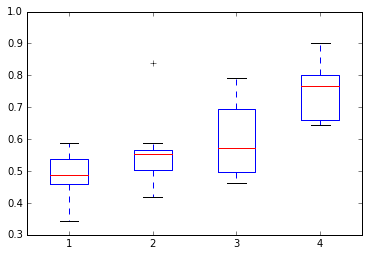

In [33]:
plt.boxplot(acc_all)
plt.show

In [34]:
np.median(SOacc)

0.48726956038769192

In [35]:
np.median(ISpec_acc)

0.55286529321191025

In [36]:
np.median(PSpec_acc)

0.57368818819032008

In [37]:
np.median(DSpec_acc)

0.7664941870963089

In [38]:
np.savetxt('results.csv', acc_all, delimiter=',') 